# ViViT-Based Eye Blink Classification

This notebook trains a ViViT (Video Vision Transformer) model for eye blink detection
using preprocessed eye-region frames and metadata extracted via MediaPipe.


## 1. Imports and Device Configuration

We use PyTorch for training, HuggingFace Transformers for ViViT,
and standard utilities for dataset handling and evaluation.


In [ ]:
import os, glob, cv2, torch, numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import VivitForVideoClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


## 2. Eye Metadata Loader

This class maps saved metadata files to their corresponding eye-region frames
stored on disk and provides frame-level access to bounding boxes and landmarks.


In [ ]:
class EyeMetadataAuto:
    """
    Loads metadata and maps to full-frame BMPs inside numeric subfolder (e.g., '13').
    """
    def __init__(self, npz_path, full_frame_root):
        self.data = np.load(npz_path)
        self.bboxes = self.data["bboxes"]
        self.landmarks = self.data["landmarks"]

        # Video ID from metadata filename
        self.video_id = os.path.splitext(os.path.basename(npz_path))[0].replace("_metadata","")

        # Detect class folder (blink/no_blink)
        class_folder = None
        for cls in ["blink","no_blink"]:
            candidate = os.path.join(full_frame_root, cls, self.video_id)
            if os.path.exists(candidate):
                class_folder = candidate
                self.cls = cls
                break
        if class_folder is None:
            raise FileNotFoundError(f"No folder found for video {self.video_id}")

        # Numeric subfolder (e.g., '13')
        subfolders = [f for f in os.listdir(class_folder) if os.path.isdir(os.path.join(class_folder,f)) and f.isdigit()]
        if len(subfolders)==0:
            raise FileNotFoundError(f"No numeric subfolder found in {class_folder}")
        self.bmp_dir = os.path.join(class_folder, sorted(subfolders)[0])

        # List and sort BMP frames numerically
        bmp_files = [f for f in os.listdir(self.bmp_dir) if f.endswith(".bmp")]
        if len(bmp_files)==0:
            raise FileNotFoundError(f"No BMP files found in {self.bmp_dir}")
        bmp_files.sort(key=lambda x:int(os.path.splitext(x)[0]))
        self.bmp_files = bmp_files
        self.start_frame_idx = int(os.path.splitext(bmp_files[0])[0])
        self.num_frames_total = len(bmp_files)

    def bbox(self,i):
        return self.bboxes[i]

    def landmarks(self,i):
        return self.landmarks[i]

    def full_frame_idx(self,i):
        return self.start_frame_idx + i

    def full_frame_path(self,i):
        idx = i
        if idx >= self.num_frames_total:
            idx = self.num_frames_total - 1
        return os.path.join(self.bmp_dir, self.bmp_files[idx])

    def num_frames(self):
        return len(self.bboxes)


## 3. Eye Cropping, Resizing, and Padding

Eye regions are cropped using bounding boxes, resized while preserving aspect ratio,
and padded to 224×224 to match ViViT input requirements.


In [ ]:
def crop_resize_pad_eye(frame, bbox, target=224):
    x,y,w,h = bbox
    crop = frame[y:y+h, x:x+w]
    h_c,w_c,_ = crop.shape
    scale = min(target/h_c, target/w_c)
    nh,nw = int(h_c*scale), int(w_c*scale)
    resized = cv2.resize(crop, (nw,nh))
    canvas = np.zeros((target,target,3),dtype=np.uint8)
    y0,x0 = (target-nh)//2, (target-nw)//2
    canvas[y0:y0+nh,x0:x0+nw] = resized
    geom = {"pad_x":x0, "pad_y":y0, "scale":scale, "crop_h":h_c, "crop_w":w_c}
    return canvas, geom

## 4. Temporal Interpolation

Since ViViT expects a fixed number of frames, sequences are temporally interpolated
or padded to 32 frames using repetition of the last valid frame.


In [ ]:
def temporal_interpolate(frames, geoms, target_frames=32):
    T = len(frames)
    if T>=target_frames:
        indices = np.linspace(0,T-1,target_frames).astype(int)
        return frames[indices], [geoms[i] for i in indices]
    else:
        reps = target_frames-T
        last_frame = frames[-1][None]
        frames = np.concatenate([frames, np.repeat(last_frame,reps,axis=0)], axis=0)
        geoms += [geoms[-1]]*reps
        return frames, geoms


## 5. Eye Blink Dataset

Custom PyTorch Dataset that:
- Loads eye-region frames
- Applies spatial and temporal preprocessing
- Returns tensors suitable for ViViT training


In [ ]:
class EyeBlinkDataset(Dataset):
    def __init__(self, meta_paths, full_frame_root, labels_dict, target_frames=32):
        self.meta_paths = meta_paths
        self.full_frame_root = full_frame_root
        self.labels_dict = labels_dict
        self.target_frames = target_frames

    def __len__(self): return len(self.meta_paths)

    def __getitem__(self,idx):
        meta_path = self.meta_paths[idx]
        meta = EyeMetadataAuto(meta_path, self.full_frame_root)
        frames, geoms = [], []
        for i in range(meta.num_frames()):
            f = cv2.imread(meta.full_frame_path(i))
            f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
            crop, geom = crop_resize_pad_eye(f, meta.bbox(i))
            frames.append(crop)
            geoms.append(geom)
        frames, geoms = temporal_interpolate(np.stack(frames), geoms, self.target_frames)
        frames = torch.from_numpy(frames).float()/255.0
        frames = frames.permute(0,3,1,2)
        vid_id = os.path.splitext(os.path.basename(meta_path))[0].replace("_metadata","")
        label = self.labels_dict[vid_id]
        return frames, torch.tensor(label)


## 6. ViViT Fine-Tuning Setup

We load a pretrained ViViT model and fine-tune only:
- The last two transformer layers
- Patch embeddings
- Classification head


In [ ]:
def load_vivit_finetune(num_classes=2):
    model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400", num_labels=num_classes, ignore_mismatched_sizes=True)
    # Freeze all except last 2 layers + embeddings + classifier
    for param in model.parameters(): param.requires_grad = False
    for name,param in model.named_parameters():
        if "encoder.layer.10" in name or "encoder.layer.11" in name or "embeddings" in name or "classifier" in name:
            param.requires_grad = True
    return model

## 7. Training and Validation Loop

The model is trained with:
- Cross-entropy loss
- Adam optimizer
- Early stopping based on validation loss

Training and validation curves are plotted for analysis.


In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_vivit_with_curves(model, train_loader, val_loader, epochs=20, lr=1e-4, device='cuda'):
    """
    Train ViViT model with early stopping, best checkpoint saving, and live batch-level progress bars.
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')
    patience, counter = 5, 0

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        running_loss, correct, total = 0, 0, 0

        for x, label in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            x, label = x.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(x).logits
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == label).sum().item()
            total += label.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # --- Validation ---
        model.eval()
        running_val_loss, correct_val, val_total = 0, 0, 0

        with torch.no_grad():
            for x, label in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                x, label = x.to(device), label.to(device)
                outputs = model(x).logits
                loss = criterion(outputs, label)

                running_val_loss += loss.item() * x.size(0)
                preds = outputs.argmax(dim=1)
                correct_val += (preds == label).sum().item()
                val_total += label.size(0)

        val_loss = running_val_loss / val_total
        val_acc = correct_val / val_total

        # --- Store metrics ---
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # --- Print epoch summary ---
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
              f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # --- Early stopping & checkpoint ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Saved best model at epoch {epoch+1}")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # --- Plot curves ---
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curves'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curves'); plt.legend()
    plt.show()

    return model


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task

Epoch 1/20 | Train Loss: 0.4717 | Val Loss: 0.5591 | Train Acc: 0.8102 | Val Acc: 0.7619
Saved best model at epoch 1


Epoch 2/20 | Train Loss: 0.3303 | Val Loss: 0.3532 | Train Acc: 0.8645 | Val Acc: 0.8452
Saved best model at epoch 2


Epoch 3/20 | Train Loss: 0.1921 | Val Loss: 0.4215 | Train Acc: 0.9307 | Val Acc: 0.7976


Epoch 4/20 | Train Loss: 0.0980 | Val Loss: 0.5447 | Train Acc: 0.9699 | Val Acc: 0.8214


Epoch 5/20 | Train Loss: 0.0718 | Val Loss: 0.4774 | Train Acc: 0.9759 | Val Acc: 0.8810


Epoch 6/20 | Train Loss: 0.0141 | Val Loss: 0.6079 | Train Acc: 0.9970 | Val Acc: 0.8452


Epoch 7/20 | Train Loss: 0.0019 | Val Loss: 0.6811 | Train Acc: 1.0000 | Val Acc: 0.8452
Early stopping at epoch 7


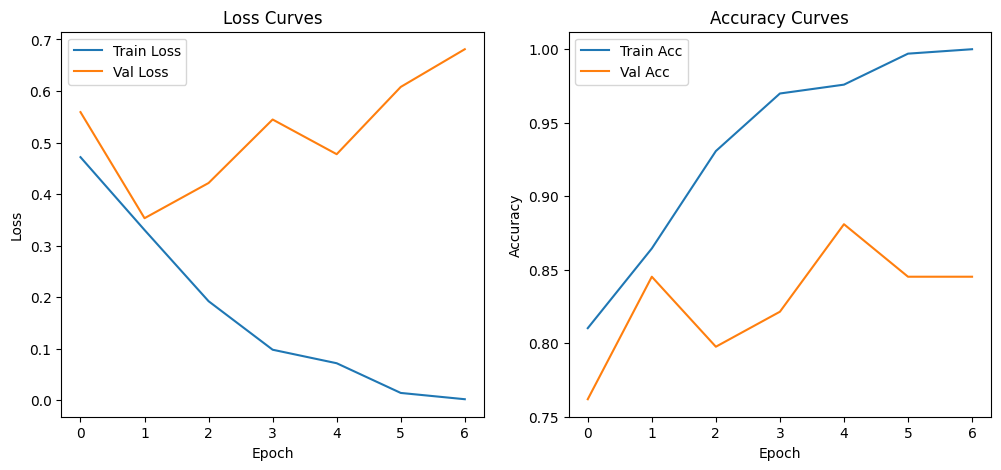

In [ ]:
full_frame_root = "/content/drive/MyDrive/training"
metadata_root = "/content/drive/MyDrive/eye_dataset_train"

# Collect metadata
blink_meta = glob.glob(f"{metadata_root}/blink/*_metadata.npz")
no_blink_meta = glob.glob(f"{metadata_root}/no_blink/*_metadata.npz")
all_meta = blink_meta + no_blink_meta

# Label dict
labels_dict = {}
for path in blink_meta:
    vid_id = os.path.splitext(os.path.basename(path))[0].replace("_metadata","")
    labels_dict[vid_id] = 1
for path in no_blink_meta:
    vid_id = os.path.splitext(os.path.basename(path))[0].replace("_metadata","")
    labels_dict[vid_id] = 0

# Train/Val split
train_meta, val_meta = train_test_split(all_meta, test_size=0.2, random_state=42,
                                       stratify=[labels_dict[os.path.splitext(os.path.basename(m))[0].replace("_metadata","")] for m in all_meta])

# Datasets & Loaders
train_ds = EyeBlinkDataset(train_meta, full_frame_root, labels_dict)
val_ds = EyeBlinkDataset(val_meta, full_frame_root, labels_dict)
train_loader = DataLoader(train_ds,batch_size=2,shuffle=True)
val_loader = DataLoader(val_ds,batch_size=2)

# Load model
model = load_vivit_finetune(num_classes=2)

# Train
model = train_vivit_with_curves(model, train_loader, val_loader, epochs=20, lr=1e-4, device=device)


## Output Artifacts

- `best_model.pth`: best-performing ViViT checkpoint
- Training & validation loss/accuracy curves
